dataset : https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

# 1 - Perkenalan

## Perkenalan Diri

Nama : Edwin Reyhan Devara Ramadhan Rasya  
Batch : FTDS-017-RMT

## Objective

Perusahaan kita bergerak pada layanan streaming film berbasis langganan. Perusahaan kita menginginkan kita (Data team or Data scientists) untuk melihat sentimen positif dan negatif film-film yang ada di imdb, yang mana nantinya film-film yang memiliki sentimen positif akan diprioritaskan untuk disewa oleh perusahaan kita untuk selanjutnya disediakan di layanan streaming kita.  

Objective : Membuat model NLP untuk melihat apakah review suatu film memiliki sentimen positif atau negatif

Karena kita ingin secara akurat memprediksi sentimen review sebagai negatif atau positif, kita akan memakai metric akurasi untuk mengukur keberhasilan model kita.  

Fokus metric: Akurasi

# 2 - Import Libraries

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Input, Bidirectional, SimpleRNN, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

from wordcloud import WordCloud

# Needed for functions
import string
import re
translator = str.maketrans('', '', string.punctuation)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop_words  = set(stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3 - Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_raw = pd.read_csv("/content/drive/MyDrive/movie.csv")

In [ ]:
data_raw.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


# 4 - EDA

In [ ]:
data_eda = data_raw.copy()

In [ ]:
data_eda.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

Data kita balance berdasarkan labelnya

In [ ]:
data_eda.loc[:,'text len'] = data_eda['text'].apply(lambda x: len(x))

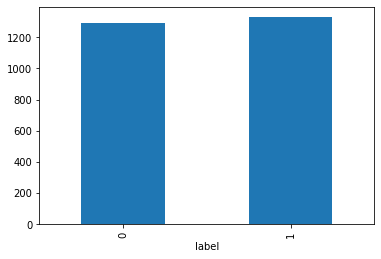

In [ ]:
data_eda.groupby('label')['text len'].mean().plot(kind='bar');

Secara rata-rata, text yang negative dan positive memiliki panjang yang sama.

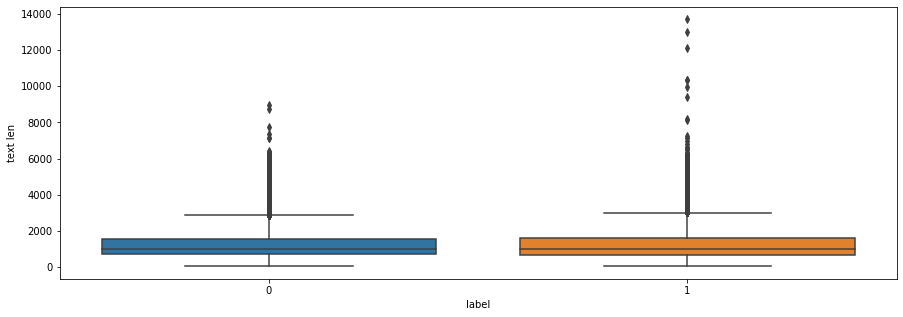

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.boxplot(ax=ax, data=data_eda, x='label', y='text len');

Jika divisualkan via boxplot, text yang negative dan positive memiliki panjang yang sama. Namun beberapa orang-orang cenderung menulis review yang panjang jika review itu positive (1). 

# 5 - Data Preprocessing

In [ ]:
data = data_raw.copy()

## Checking missing value

In [ ]:
data.isnull().sum()

text     0
label    0
dtype: int64

Data kita tidak memiliki missing value di text maupun labelnya.

## Checking duplicates

In [ ]:
data[data.duplicated()]

,text,label
2164,"I find it rather useless to comment on this ""m...",0
3236,An absolutely atrocious adaptation of the wond...,0
3428,When I first saw this film it was not an impre...,0
3652,Before I watched this tv movie I did not know ...,1
3787,What a clunker!<br /><br />It MUST have been m...,0
...,...,...
39229,I Enjoyed Watching This Well Acted Movie Very ...,1
39246,You do realize that you've been watching the E...,0
39508,(Spoilers)<br /><br />Oh sure it's based on Mo...,0
39681,It's been a long time since I last saw a movie...,0


Data kita memiliki 277 duplikat reviews. Kita ingin menghapus duplikat ini.

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data[data.duplicated()]

,text,label


Review dupliklat sudah terhapus.

In [ ]:
# membuat fungsi untuk memilih 5 reviews secara random untuk melihat text-text aneh yang perlu dihapus
def pilih_random(data, kolom):
  series = data[kolom].sample(5)
  df_kosong = pd.DataFrame()
  list_index = []
  list_value = []
  for index, value in series.items():
    list_index.append(index)
    list_value.append(value)

  df_kosong['index'] = list_index
  df_kosong['value'] = list_value
  
  return f"Index {df_kosong.loc[0,'index']}: {df_kosong.loc[0,'value']}", \
  f"Index {df_kosong.loc[1,'index']}: {df_kosong.loc[1,'value']}", \
  f"Index {df_kosong.loc[2,'index']}: {df_kosong.loc[2,'value']}", \
  f"Index {df_kosong.loc[3,'index']}: {df_kosong.loc[3,'value']}", \
  f"Index {df_kosong.loc[4,'index']}: {df_kosong.loc[4,'value']}",

In [ ]:
# contoh review yang ada element yang perlu dihapus yang didapatkan dengan fungsi pilih_random
data_7483_sebelum = data.text[7483]
data_7483_sebelum

'In the wasteland that Hollywood Productions have become of late, this movie - in and of itself - is truly "MANNA FROM HEAVEN"!!!<br /><br />In what could best be described as a "cute" movie, approximately 350 years of movie acting experience (allright - give or take 100 years!) joyously lights up the screen to tell a tale of deceit, remorse, and redemption about a Catholic Family in Buffalo, NY.<br /><br />Truly well-positioned to take its place in the "feel-good" movie genre, this quiet little independent film by the Burton Sisters\' FIVE SISTERS PRODUCTIONS COMPANY will leave a smile on your face and joy in your heart, all while renewing your faith in mankind.<br /><br />From the spectacular opening scene shots of Buffalo, NY to the final credits, the film manages to tell a tale that could have been told of any family, anywhere. Yet, somehow this particular gathering of family and "family by association" in a small, non-descript house in Buffalo more than fits the bill. If you\'ve n

## Menghapus elemen-elemen aneh dari reviews

In [ ]:
# membuat fungsi untuk menghapus elemen-elemen aneh di dalam reviews
def text_preprocess(row):

  row = row.lower()

  # Menghilangkan tanda baca
  translator = str.maketrans('', '', string.punctuation)
  row = row.translate(translator)

  # Menghilangkan semua link
  row = re.sub(r'https?\S+', ' ', row)
  row = re.sub(r'www.?\S+', ' ', row)

  # Menghilangkan < > br dan /
  row = ' '.join(x.replace('<', '').replace('>', '').replace('br', '').replace('/', '') for x in row.split())

  # Menghilangkan tanda baca (special characters) dan numeric
  # [^a-zA-z\s]
  row = re.sub('[^a-zA-z\s]', ' ', row)

  # Menghilangkan single alphabet kecuali a, i, u
  row = ' '.join([x for x in row.split() if (x in ['a', 'i', 'u']) | (len(x)>1)])

  # Menghilangkan stopwords
  row = ' '.join([x for x in row.split() if x not in stop_words])

  # Menghilangkan white space
  row = row.strip()

  # Menghilangkan extra white space (sama dengan split dan join)
  row = re.sub(' +', ' ', row)

  return row

In [ ]:
# melakukan pembersihan elemen-elemen aneh di reviews dengan fungsi text_preprocess
data['text_processed'] = data['text'].apply(lambda x: text_preprocess(x))

In [ ]:
# melihat beberapa review sebelum dipreprocess dan setelah
data.head()

,text,label,text_processed
0,I grew up (b. 1965) watching and loving the Th...,0,grew watching loving thunderbirds mates school...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chips expectatio...
2,Why do people who do not know what a particula...,0,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movies bor...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dads army fan nothing ever change ...


In [ ]:
# review baris 7484 sebelum dipreprocess
data_7483_sebelum

'In the wasteland that Hollywood Productions have become of late, this movie - in and of itself - is truly "MANNA FROM HEAVEN"!!!<br /><br />In what could best be described as a "cute" movie, approximately 350 years of movie acting experience (allright - give or take 100 years!) joyously lights up the screen to tell a tale of deceit, remorse, and redemption about a Catholic Family in Buffalo, NY.<br /><br />Truly well-positioned to take its place in the "feel-good" movie genre, this quiet little independent film by the Burton Sisters\' FIVE SISTERS PRODUCTIONS COMPANY will leave a smile on your face and joy in your heart, all while renewing your faith in mankind.<br /><br />From the spectacular opening scene shots of Buffalo, NY to the final credits, the film manages to tell a tale that could have been told of any family, anywhere. Yet, somehow this particular gathering of family and "family by association" in a small, non-descript house in Buffalo more than fits the bill. If you\'ve n

In [ ]:
# review baris 7484 setelah dipreprocess
data['text_processed'][7483]

'wasteland hollywood productions become late movie truly manna heaven could best described cute movie approximately years movie acting experience allright give take years joyously lights screen tell tale deceit remorse redemption catholic family buffalo ny truly wellpositioned take place feelgood movie genre quiet little independent film burton sisters five sisters productions company leave smile face joy heart renewing faith mankind spectacular opening scene shots buffalo ny final credits film manages tell tale could told family anywhere yet somehow particular gathering family family association small nondescript house buffalo fits bill youve never buffalo youll leave theater thoughts shuffling visit shots city landmarks surroundings help ing quaint earth tone film suits fine quiet beauty queen city great lakes compliments rather detracts tale told movies would take advantage natural beauty countrys second cities instead running soundstage somewhere end results would much believable g

In [ ]:
# melihat reviews yang sudah dipreprocess secara random
pilih_sembarang = pilih_random(data, 'text_processed')
pilih_sembarang

('Index 36550: watched film last night though would rent horrorscary film blockbusters got one opening scenes long winded conversations characters seemed lead anywhere story line seemed poor gave hiv goes meet someone else killed man infected think may long time different people dumps body happened man going meet forest saw dumping body chased ever finish burying body got car somehow found different direction came killed bloke think severed head good thing film quite realistic woman ran happened fall front could stab spade finished relief pointless film ever watchedplease steer well clear poorly made counted different people scene kills unrealistic swear thats thats steer well clear',
 'Index 1659: great subject matter director cast somehow adds truly abysmal film told flat semidocumentary style popular around time film made hello filmnoir lackluster overly complicated overpopulated story arc focus point little excitement staggers one scene next discernible purpose valentine supposed h

### Wordcloud for the data

In [ ]:
reviews_string = data['text_processed'].str.cat()

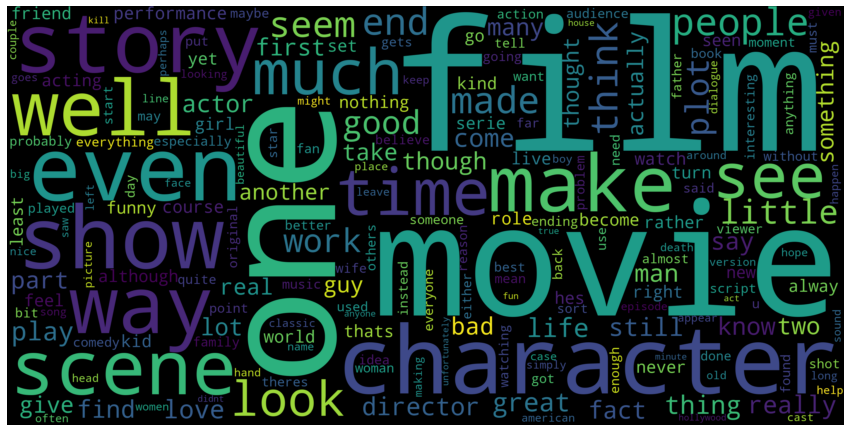

In [ ]:
wordcloud = WordCloud(background_color='black', width = 3000, height = 1500).generate(reviews_string)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_data.png', dpi=300);

Kata-kata yang sering dipakai di reviews adalah film, movie, character, one, even, dll.

## Split the Data

In [ ]:
# Assign reviews yang sudah dipreprocess ke variable X
X = data['text_processed']

In [ ]:
# Assign label ke variable y
y = data.label

In [ ]:
# Split data to Training Set, Validation Set, and Testing Set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.30, shuffle=True, random_state=0)

In [ ]:
print('Training Set Shape : ', X_train.shape, y_train.shape)
print('Validation Set Shape : ', X_val.shape, y_val.shape)
print('Testing Set Shape : ', X_test.shape, y_test.shape)

Training Set Shape :  (23634,) (23634,)
Validation Set Shape :  (10130,) (10130,)
Testing Set Shape :  (5959,) (5959,)


### Wordcloud for X_train

In [ ]:
reviews_string_train = X_train.str.cat()

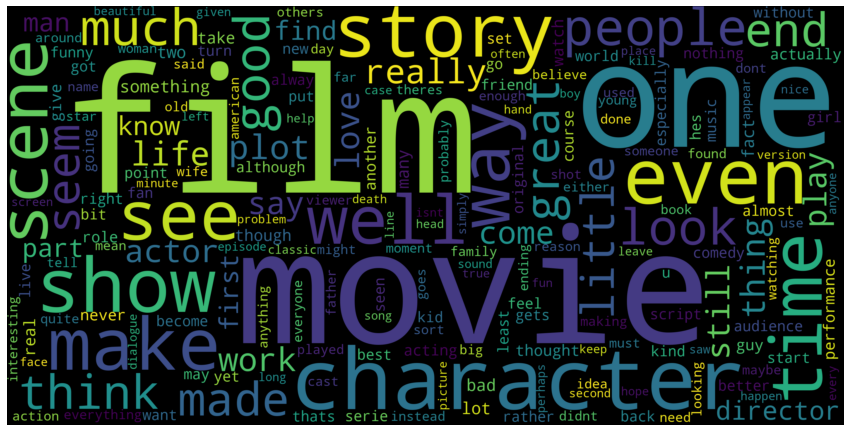

In [ ]:
wordcloud = WordCloud(background_color='black', width = 3000, height = 1500).generate(reviews_string_train)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_train.png', dpi=300);

Kata-kata yang sering dipakai di reviews pada data training hampir sama dengan data keseluruhan, yaitu film, movie, character, dll.

### Wordcloud for X_val

In [ ]:
reviews_string_val = X_val.str.cat()

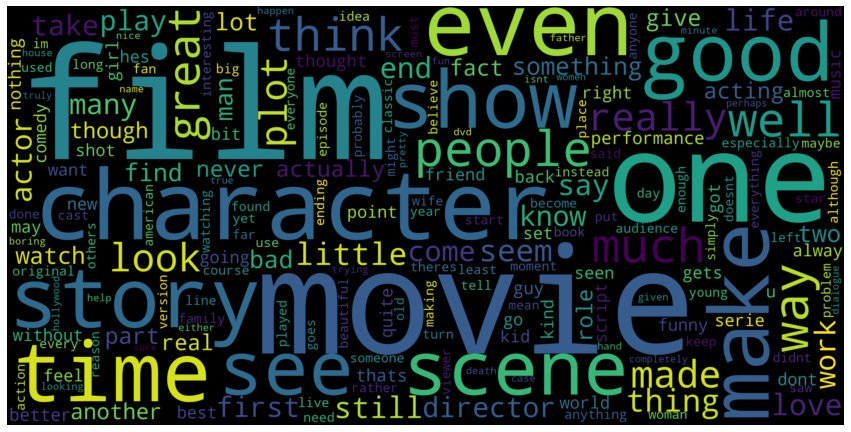

In [ ]:
wordcloud = WordCloud(background_color='black', width = 3000, height = 1500).generate(reviews_string_val)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_val.png', dpi=300);

Kata-kata yang sering dipakai di reviews pada data validation hampir sama dengan data keseluruhan dan training, yaitu yang paling sering muncul adalah film, movie, character, dll.

## Text Vectorization and Embedding

### Menghitung unique vocabularies

In [ ]:
# Menggunakan CountVectorizer untuk menghitung jumlah unique vocabulary (values) di masing-masing review
count_vect_stopwords = CountVectorizer(stop_words = stop_words)

In [ ]:
count_vect_stopwords.fit(X_train)

CountVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [ ]:
# Menghitung jumlah unique vocabulary (values) di masing-masing review dan panjang review terpanjang
vocab_total = len(count_vect_stopwords.vocabulary_.keys())
max_length_of_text = max([len(x.split()) for x in X_train])

In [ ]:
vocab_total

107053

Data kita memiliki 107.053 unique vocabularies.

In [ ]:
max_length_of_text

1407

Review terpanjang di data kita memiliki panjang 1407 kata.

### TextVectorization

Karena kita tidak bisa mamasukkan data sparse dari CountVectorizer tidak bisa dipakai oleh tensorflow, kita memakai fungsi TextVectorization dari tensorflow agar bisa dipakai oleh model tensorflow kita. CountVectorizer dan TextVectorization memiliki fungsi yang sama. Namun, hasil dari TextVectorization belum berbentuk angka seperti CountVectorizer. Maka dari itu kita masih butuh satu proses lagi, yaitu embedding.

In [ ]:
text_vect = TextVectorization(max_tokens=vocab_total,
                              output_sequence_length=max_length_of_text,
                              input_shape=(1,)
                              )

In [ ]:
# adapt datanya (melakukan analisis data dan membuat vocabulary berdasarkan frequencynya)
text_vect.adapt(X_train)

In [ ]:
text_vect.get_vocabulary()[:30]

['',
 '[UNK]',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'even',
 'time',
 'would',
 'really',
 'see',
 'story',
 'well',
 'much',
 'get',
 'also',
 'great',
 'bad',
 'people',
 'first',
 'dont',
 'movies',
 'make',
 'way',
 'films',
 'made',
 'could',
 'characters',
 'think']

mungkin bisa dihilangkan:  
one, even, would, also, 

kata-kata yang sama:
film films  


### Embedding

Karena kita sudah melakukan text vectorization, kita butuh melakukan embedding untuk mengubahnya ke angka agar bisa dimasukkan ke deep learning.

In [ ]:
embedding = Embedding(input_dim=vocab_total,
                      output_dim=10,
                      embeddings_initializer='uniform',
                      input_length=max_length_of_text
                      )

# 6 - Modeling

## Base Model

### Simple RNN 1

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

rnn_1 = Sequential()
rnn_1.add(text_vect)
rnn_1.add(embedding)
rnn_1.add(SimpleRNN(12))
rnn_1.add(Dense(1, activation='sigmoid'))

rnn_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics='accuracy')

rnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 simple_rnn (SimpleRNN)      (None, 12)                276       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 1,070,099
Trainable params: 1,070,099
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
rnn_1_history = rnn_1.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
47/47 [==============================] - 86s 2s/step - loss: 0.6943 - accuracy: 0.5045 - val_loss: 0.6940 - val_accuracy: 0.4905
Epoch 2/10
47/47 [==============================] - 79s 2s/step - loss: 0.6940 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 3/10
47/47 [==============================] - 98s 2s/step - loss: 0.6935 - accuracy: 0.5035 - val_loss: 0.6936 - val_accuracy: 0.4905
Epoch 4/10
47/47 [==============================] - 81s 2s/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5095
Epoch 5/10
47/47 [==============================] - 81s 2s/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6937 - val_accuracy: 0.4905
Epoch 6/10
47/47 [==============================] - 79s 2s/step - loss: 0.6934 - accuracy: 0.5011 - val_loss: 0.6938 - val_accuracy: 0.4905
Epoch 7/10
47/47 [==============================] - 77s 2s/step - loss: 0.6934 - accuracy: 0.5024 - val_loss: 0.6938 - val_accuracy: 0.4905
Epoch 8/10
47/47 [==

In [ ]:
rnn_1_history_df = pd.DataFrame(rnn_1_history.history)
rnn_1_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.694347,0.504454,0.693960,0.490490
1,0.694010,0.496303,0.693201,0.490490
2,0.693501,0.503529,0.693572,0.490490
3,0.693323,0.502101,0.693085,0.509510
4,0.693238,0.500588,0.693689,0.490490
5,0.693356,0.501134,0.693792,0.490490
6,0.693408,0.502437,0.693762,0.490490
7,0.693358,0.499664,0.695784,0.490490
8,0.695712,0.499748,0.702588,0.497647
9,0.695475,0.498361,0.693809,0.490490


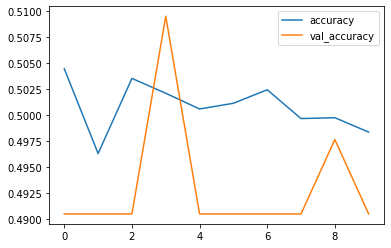

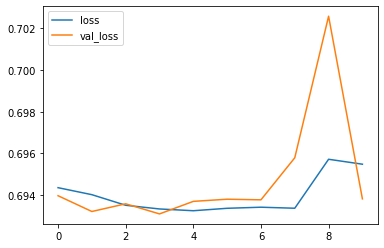

In [ ]:
rnn_1_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('rnn_1_accuracy.png', dpi=300)
rnn_1_history_df[['loss', 'val_loss']].plot()
plt.savefig('rnn_1_loss.png', dpi=300);

Karena akurasi validation set seperti atau hampir tidak bergerak, maka kita akan mencoba menggunakan Bidirectional.

In [ ]:
y_hat_rnn_1 = rnn_1.predict(X_test)
y_hat_rnn_1 = np.where(y_hat_rnn_1 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_rnn_1))

188/188 [==============================] - 21s 112ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2992
           1       0.00      0.00      0.00      3008

    accuracy                           0.50      6000
   macro avg       0.25      0.50      0.33      6000
weighted avg       0.25      0.50      0.33      6000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_score(y_test, y_hat_rnn_1)

0.49866666666666665

## Model Improvement

### Simple RNN 2

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

rnn_2 = Sequential()
rnn_2.add(text_vect)
rnn_2.add(embedding)
rnn_2.add(Bidirectional(SimpleRNN(8)))
rnn_2.add(Dense(1, activation='sigmoid'))

rnn_2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics='accuracy')

rnn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 bidirectional (Bidirectiona  (None, 16)               304       
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,070,131
Trainable params: 1,070,131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
rnn_2_history = rnn_2.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
47/47 [==============================] - 159s 3s/step - loss: 0.3980 - accuracy: 0.8243 - val_loss: 0.5593 - val_accuracy: 0.7781
Epoch 2/10
47/47 [==============================] - 151s 3s/step - loss: 0.2087 - accuracy: 0.9295 - val_loss: 0.5734 - val_accuracy: 0.7730
Epoch 3/10
47/47 [==============================] - 150s 3s/step - loss: 0.1453 - accuracy: 0.9523 - val_loss: 0.6144 - val_accuracy: 0.7873
Epoch 4/10
47/47 [==============================] - 149s 3s/step - loss: 0.1100 - accuracy: 0.9646 - val_loss: 0.6793 - val_accuracy: 0.7878
Epoch 5/10
47/47 [==============================] - 152s 3s/step - loss: 0.0599 - accuracy: 0.9830 - val_loss: 0.6929 - val_accuracy: 0.7920
Epoch 6/10
47/47 [==============================] - 175s 4s/step - loss: 0.0572 - accuracy: 0.9842 - val_loss: 0.7953 - val_accuracy: 0.7846
Epoch 7/10
47/47 [==============================] - 149s 3s/step - loss: 0.0507 - accuracy: 0.9870 - val_loss: 0.7652 - val_accuracy: 0.7617
Epoch 8/10
47

In [ ]:
rnn_2_history_df = pd.DataFrame(rnn_2_history.history)
rnn_2_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.398019,0.824328,0.559266,0.778137
1,0.208706,0.929454,0.573401,0.773039
2,0.145261,0.952269,0.614400,0.787255
3,0.109992,0.964622,0.679338,0.787843
4,0.059890,0.982983,0.692893,0.791961
5,0.057168,0.984244,0.795288,0.784608
6,0.050725,0.987017,0.765223,0.761667
7,0.066139,0.979328,0.776877,0.767941
8,0.051544,0.984034,0.838491,0.787157
9,0.038303,0.989034,0.941576,0.783922


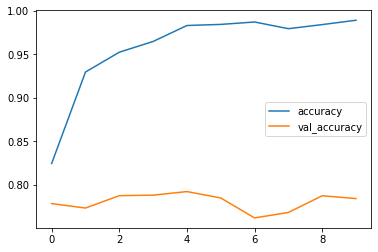

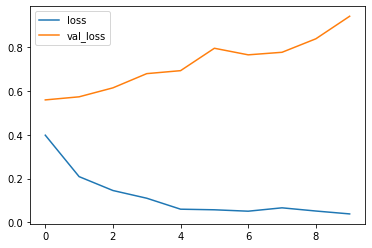

In [ ]:
rnn_2_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('rnn_2_accuracy.png', dpi=300)
rnn_2_history_df[['loss', 'val_loss']].plot()
plt.savefig('rnn_2_loss.png', dpi=300);

Akurasi dan loss pada validation set sudah bisa berkembang, namun model kita sangat overfit. Perbedaan antara akurasi pada training dan akurasi pada validation set adalah sekitar 20%.

In [ ]:
y_hat_rnn_2 = rnn_2.predict(X_test)
y_hat_rnn_2 = np.where(y_hat_rnn_2 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_rnn_2))

188/188 [==============================] - 46s 239ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2992
           1       0.80      0.76      0.78      3008

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



In [ ]:
accuracy_score(y_test, y_hat_rnn_2)

0.7855

Akurasi pada tes set juga improve tapi sekali lagi, model kita terlalu overfit.

Karena hasil SimpleRNN tidak overfit dan lama trainingnya, kita akan mencoba LSTM dan GRU.

### LSTM

#### LSTM 1

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

lstm_1 = Sequential()
lstm_1.add(text_vect)
lstm_1.add(embedding)
lstm_1.add(LSTM(64))
lstm_1.add(Dense(256, activation='relu'))
lstm_1.add(Dropout(0.5))
lstm_1.add(Dense(1, activation='sigmoid'))

lstm_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [ ]:
%%time
lstm_1_history = lstm_1.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=200,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
119/119 [==============================] - 29s 227ms/step - loss: 0.6936 - accuracy: 0.4995 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 2/10
119/119 [==============================] - 24s 203ms/step - loss: 0.6936 - accuracy: 0.4985 - val_loss: 0.6936 - val_accuracy: 0.4905
Epoch 3/10
119/119 [==============================] - 22s 185ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6940 - val_accuracy: 0.4905
Epoch 4/10
119/119 [==============================] - 22s 182ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 5/10
119/119 [==============================] - 19s 164ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6936 - val_accuracy: 0.4905
Epoch 6/10
119/119 [==============================] - 18s 156ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4905
Epoch 7/10
119/119 [==============================] - 19s 156ms/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6935 - val_ac

Kita sudah melakukan improvement pada kecepatan modeling. Dengan SimpleRNN yang bisa lebih dari 10 menit. Dengan LSTM kita hanya butuh 2 menitan.

In [ ]:
lstm_1_history_df = pd.DataFrame(lstm_1_history.history)
lstm_1_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.693603,0.499496,0.693345,0.49049
1,0.693628,0.498487,0.693605,0.49049
2,0.693251,0.502857,0.693954,0.49049
3,0.693259,0.499748,0.693329,0.49049
4,0.693057,0.506891,0.693601,0.49049
5,0.693105,0.505756,0.693725,0.49049
6,0.693287,0.500462,0.693546,0.49049
7,0.693200,0.503193,0.693982,0.49049
8,0.693288,0.500210,0.693645,0.49049
9,0.693314,0.499454,0.693330,0.49049


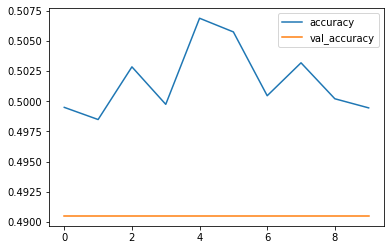

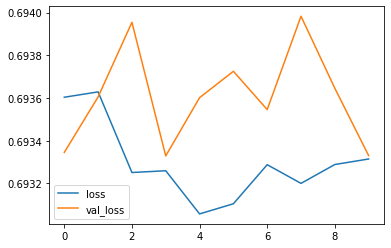

In [ ]:
lstm_1_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('lstm_1_accuracy.png', dpi=300)
lstm_1_history_df[['loss', 'val_loss']].plot()
plt.savefig('lstm_1_loss.png', dpi=300);

Karena akurasi validation set tidak bergerak, maka kita juga akan menggunakan Bidirectional seperti di SimpleRNN.

In [ ]:
y_hat_lstm_1 = lstm_1.predict(X_test)
y_hat_lstm_1 = np.where(y_hat_lstm_1 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_lstm_1))

188/188 [==============================] - 4s 17ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2992
           1       0.00      0.00      0.00      3008

    accuracy                           0.50      6000
   macro avg       0.25      0.50      0.33      6000
weighted avg       0.25      0.50      0.33      6000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_score(y_test, y_hat_lstm_1)

0.49866666666666665

#### LSTM 2

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

lstm_2 = Sequential()
lstm_2.add(text_vect)
lstm_2.add(embedding)
lstm_2.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_2.add(Bidirectional(LSTM(32)))
lstm_2.add(Dense(64, activation='relu'))
lstm_2.add(Dense(1, activation='sigmoid'))

lstm_2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 bidirectional (Bidirectiona  (None, 1407, 128)        38400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
%%time
lstm_2_history = lstm_2.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=200,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
119/119 [==============================] - 50s 349ms/step - loss: 0.5762 - accuracy: 0.6717 - val_loss: 0.4077 - val_accuracy: 0.8243
Epoch 2/10
119/119 [==============================] - 40s 338ms/step - loss: 0.2900 - accuracy: 0.8878 - val_loss: 0.3200 - val_accuracy: 0.8657
Epoch 3/10
119/119 [==============================] - 42s 349ms/step - loss: 0.1544 - accuracy: 0.9472 - val_loss: 0.3400 - val_accuracy: 0.8742
Epoch 4/10
119/119 [==============================] - 38s 323ms/step - loss: 0.0856 - accuracy: 0.9742 - val_loss: 0.4915 - val_accuracy: 0.8536
Epoch 5/10
119/119 [==============================] - 38s 319ms/step - loss: 0.0439 - accuracy: 0.9881 - val_loss: 0.5650 - val_accuracy: 0.8538
Epoch 6/10
119/119 [==============================] - 37s 311ms/step - loss: 0.0257 - accuracy: 0.9940 - val_loss: 0.6674 - val_accuracy: 0.8534
Epoch 7/10
119/119 [==============================] - 37s 308ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.6660 - val_ac

In [ ]:
lstm_2_history_df = pd.DataFrame(lstm_2_history.history)
lstm_2_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.576163,0.671723,0.407709,0.824314
1,0.290007,0.887773,0.320014,0.865686
2,0.154404,0.947227,0.340030,0.874216
3,0.085564,0.974202,0.491500,0.853627
4,0.043896,0.988109,0.565040,0.853824
5,0.025746,0.994034,0.667354,0.853431
6,0.017948,0.996092,0.666046,0.856863
7,0.028265,0.992815,0.658624,0.848824
8,0.014910,0.996471,0.885087,0.829804
9,0.010086,0.997689,0.804149,0.845098


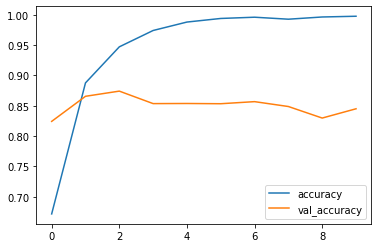

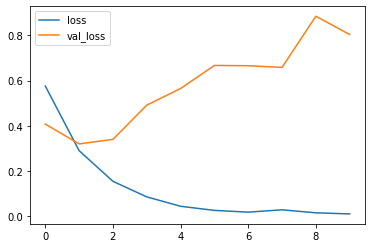

In [ ]:
lstm_2_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('lstm_2_accuracy.png', dpi=300)
lstm_2_history_df[['loss', 'val_loss']].plot()
plt.savefig('lstm_2_loss.png', dpi=300);

Hasil dari lstm_2 overfit, yaitu dengan jarak sekitar 15% antara akurasi training dan akurasi validation dataset.

In [ ]:
y_hat_lstm_2 = lstm_2.predict(X_test)
y_hat_lstm_2 = np.where(y_hat_lstm_2 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_lstm_2))

188/188 [==============================] - 16s 68ms/step
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      2992
           1       0.81      0.88      0.84      3008

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



In [ ]:
accuracy_score(y_test, y_hat_lstm_2)

0.838

Akurasi pada tes set membaik, namun model kita overfit.

#### LSTM 3

Karena model lstm_2 overfit, kita ingin mencoba bagaimana jika kita tambah hidden layernya. Kita akan menambah 1 lstm layer dan 2 dense layer, ditambah dengan dropout untuk mengatasi overfitnya. Learning rate adam juga kita ubah ke 0.0001.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

lstm_3 = Sequential()
lstm_3.add(text_vect)
lstm_3.add(embedding)
lstm_3.add(Bidirectional(LSTM(128, return_sequences=True)))
lstm_3.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_3.add(Bidirectional(LSTM(32)))
lstm_3.add(Dense(16, activation='relu'))
lstm_3.add(Dropout(0.5))
lstm_3.add(Dense(2, activation='relu'))
lstm_3.add(Dense(1, activation='sigmoid'))

lstm_3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics='accuracy')

lstm_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 bidirectional (Bidirectiona  (None, 1407, 256)        142336    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1407, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

In [ ]:
%%time
lstm_3_history = lstm_3.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
47/47 [==============================] - 79s 1s/step - loss: 0.6587 - accuracy: 0.5868 - val_loss: 0.6270 - val_accuracy: 0.6614
Epoch 2/10
47/47 [==============================] - 60s 1s/step - loss: 0.4729 - accuracy: 0.8423 - val_loss: 0.5409 - val_accuracy: 0.8456
Epoch 3/10
47/47 [==============================] - 56s 1s/step - loss: 0.3942 - accuracy: 0.9675 - val_loss: 0.6039 - val_accuracy: 0.8615
Epoch 4/10
47/47 [==============================] - 59s 1s/step - loss: 0.3774 - accuracy: 0.9867 - val_loss: 0.7044 - val_accuracy: 0.8483
Epoch 5/10
47/47 [==============================] - 59s 1s/step - loss: 0.3708 - accuracy: 0.9915 - val_loss: 0.7366 - val_accuracy: 0.8557
Epoch 6/10
47/47 [==============================] - 59s 1s/step - loss: 0.3695 - accuracy: 0.9909 - val_loss: 0.7150 - val_accuracy: 0.8588
Epoch 7/10
47/47 [==============================] - 56s 1s/step - loss: 0.3667 - accuracy: 0.9940 - val_loss: 0.7476 - val_accuracy: 0.8528
Epoch 8/10
47/47 [==

Waktu yang dibutuhkan lstm_3 lebih lama dari lstm_2.

In [ ]:
lstm_3_history_df = pd.DataFrame(lstm_3_history.history)
lstm_3_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.658697,0.586807,0.626983,0.661373
1,0.472942,0.842269,0.540925,0.845588
2,0.394161,0.967479,0.603945,0.861471
3,0.377353,0.986681,0.704447,0.848333
4,0.370804,0.991513,0.736589,0.855686
5,0.369503,0.990924,0.714971,0.858824
6,0.366718,0.993992,0.747572,0.852843
7,0.365508,0.993403,0.727825,0.853529
8,0.363861,0.993571,0.699497,0.856569
9,0.361703,0.993361,0.702311,0.857451


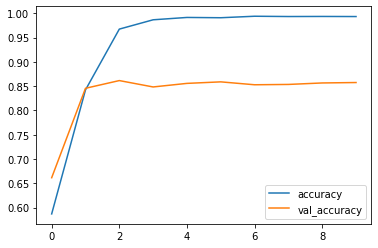

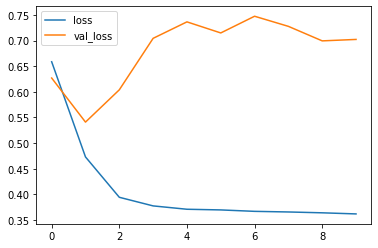

In [ ]:
lstm_3_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('lstm_3_accuracy.png', dpi=300)
lstm_3_history_df[['loss', 'val_loss']].plot()
plt.savefig('lstm_3_loss.png', dpi=300);

Model lstm_3 kita masih overfit sekitar 15% pada akurasi, yang mana menunjukkan bahwa model kita tidak berkembang, atau bahkan lebih jelek karena waktu yang dibutuhkan untuk training lebih lama dari pada lstm_2.

In [ ]:
y_hat_lstm_3 = lstm_3.predict(X_test)
y_hat_lstm_3 = np.where(y_hat_lstm_3 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_lstm_3))

188/188 [==============================] - 22s 104ms/step
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2992
           1       0.84      0.88      0.86      3008

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



In [ ]:
accuracy_score(y_test, y_hat_lstm_3)

0.8558333333333333

Akurasi pada tes set lebih bari dari lstm_2. Tapi model kita masih overfit.

#### LSTM 4

Karena dengan menambahkan jumlah hidden layer menyebabkan model masih overfit pada model lstm_3, maka dari itu kita ingin malakukan sebaliknnya, yaitu melakukan pengurangan hidden layer lstm dan dense. Kita juga akan mengurangi jumlah neuronnya jadi 12 dan menetapkkan learning rate Adam di 0.001.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

lstm_4 = Sequential()
lstm_4.add(text_vect)
lstm_4.add(embedding)
lstm_4.add(Bidirectional(LSTM(12)))
lstm_4.add(Dense(1, activation='sigmoid'))

lstm_4.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

lstm_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 bidirectional (Bidirectiona  (None, 24)               2208      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 1,072,043
Trainable params: 1,072,043
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
lstm_4_history = lstm_4.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
47/47 [==============================] - 22s 282ms/step - loss: 0.6899 - accuracy: 0.5624 - val_loss: 0.6788 - val_accuracy: 0.6863
Epoch 2/10
47/47 [==============================] - 12s 248ms/step - loss: 0.6625 - accuracy: 0.6918 - val_loss: 0.6113 - val_accuracy: 0.5728
Epoch 3/10
47/47 [==============================] - 11s 237ms/step - loss: 0.5397 - accuracy: 0.8001 - val_loss: 0.5004 - val_accuracy: 0.8332
Epoch 4/10
47/47 [==============================] - 12s 249ms/step - loss: 0.4066 - accuracy: 0.8953 - val_loss: 0.4096 - val_accuracy: 0.8651
Epoch 5/10
47/47 [==============================] - 11s 242ms/step - loss: 0.2850 - accuracy: 0.9328 - val_loss: 0.3412 - val_accuracy: 0.8796
Epoch 6/10
47/47 [==============================] - 11s 244ms/step - loss: 0.2225 - accuracy: 0.9474 - val_loss: 0.3382 - val_accuracy: 0.8723
Epoch 7/10
47/47 [==============================] - 11s 229ms/step - loss: 0.1666 - accuracy: 0.9658 - val_loss: 0.3231 - val_accuracy: 0.8775

Model lstm 4 dapat dilatih dengan waktu 1 menitan saja, yang mana hal ini adalah perkembangan yang signifikan.

In [ ]:
lstm_4_history_df = pd.DataFrame(lstm_4_history.history)
lstm_4_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.689895,0.562395,0.678822,0.686275
1,0.662539,0.691849,0.611260,0.572843
2,0.539654,0.800126,0.500434,0.833235
3,0.406640,0.895252,0.409648,0.865098
4,0.284992,0.932773,0.341224,0.879608
5,0.222524,0.947437,0.338220,0.872255
6,0.166605,0.965840,0.323070,0.877451
7,0.144329,0.969580,0.331060,0.877647
8,0.114946,0.978151,0.355749,0.872157
9,0.101104,0.980210,0.350572,0.870980


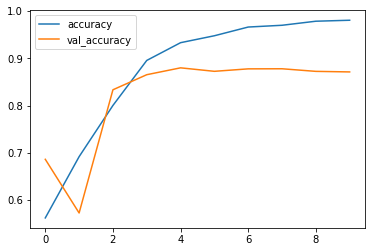

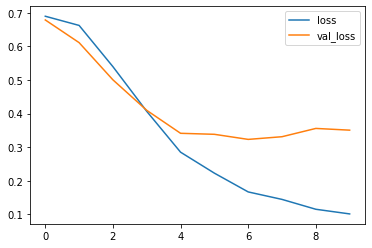

In [ ]:
lstm_4_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('lstm_4_accuracy.png', dpi=300)
lstm_4_history_df[['loss', 'val_loss']].plot()
plt.savefig('lstm_4_loss.png', dpi=300);

Kita bisa melihat bahwa model lstm_4 dapat mengurangi jarak overfit antara akurasi training dan validation, dari sekitar 15% pada lstm_3 turun jadi sekitar 10% pada lstm_4.

In [ ]:
y_hat_lstm_4 = lstm_4.predict(X_test)
y_hat_lstm_4 = np.where(y_hat_lstm_4 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_lstm_4))

188/188 [==============================] - 5s 26ms/step
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2992
           1       0.85      0.90      0.88      3008

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



In [ ]:
accuracy_score(y_test, y_hat_lstm_4)

0.8725

Akurasi pada tes set juga berkembang lebih bari dari akurasi tes set pada model lstm_3.

#### LSTM 5

Karena masalah overfit sudah berkembang lebih baik sedikit, kita ingin mengembangkan akurasi pada testing score. Kita hanya akan menambahkan 1 layer lstm dengan settingan yang lain sama.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

lstm_5 = Sequential()
lstm_5.add(text_vect)
lstm_5.add(embedding)
lstm_5.add(Bidirectional(LSTM(12, return_sequences=True)))
lstm_5.add(Bidirectional(LSTM(4)))
lstm_5.add(Dense(1, activation='sigmoid'))

lstm_5.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

lstm_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 bidirectional (Bidirectiona  (None, 1407, 24)         2208      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 8)                928       
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                        

In [ ]:
%%time
lstm_5_history = lstm_5.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
47/47 [==============================] - 25s 373ms/step - loss: 0.6820 - accuracy: 0.5640 - val_loss: 0.6398 - val_accuracy: 0.6887
Epoch 2/10
47/47 [==============================] - 15s 323ms/step - loss: 0.5151 - accuracy: 0.8562 - val_loss: 0.4585 - val_accuracy: 0.8553
Epoch 3/10
47/47 [==============================] - 15s 313ms/step - loss: 0.3191 - accuracy: 0.9577 - val_loss: 0.3921 - val_accuracy: 0.8650
Epoch 4/10
47/47 [==============================] - 15s 312ms/step - loss: 0.2230 - accuracy: 0.9790 - val_loss: 0.3550 - val_accuracy: 0.8762
Epoch 5/10
47/47 [==============================] - 14s 309ms/step - loss: 0.1689 - accuracy: 0.9873 - val_loss: 0.3559 - val_accuracy: 0.8734
Epoch 6/10
47/47 [==============================] - 14s 308ms/step - loss: 0.1399 - accuracy: 0.9877 - val_loss: 0.3675 - val_accuracy: 0.8718
Epoch 7/10
47/47 [==============================] - 15s 317ms/step - loss: 0.1196 - accuracy: 0.9885 - val_loss: 0.3936 - val_accuracy: 0.8563

Waktu yang dibutuhkan lebih lama sedikit dari lstm_4.

In [ ]:
lstm_5_history_df = pd.DataFrame(lstm_5_history.history)
lstm_5_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.681952,0.563992,0.639784,0.688725
1,0.515051,0.856176,0.458500,0.855294
2,0.319131,0.957731,0.392077,0.865000
3,0.222981,0.978992,0.355002,0.876176
4,0.168858,0.987269,0.355933,0.873431
5,0.139928,0.987731,0.367530,0.871765
6,0.119566,0.988529,0.393607,0.856274
7,0.105122,0.989202,0.376054,0.872353
8,0.085419,0.992101,0.374013,0.873333
9,0.071293,0.992605,0.389358,0.873824


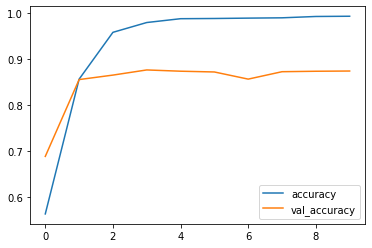

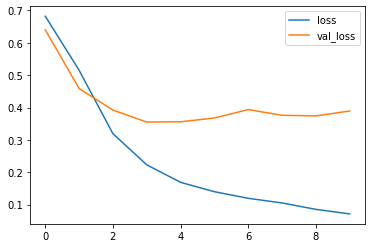

In [ ]:
lstm_5_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('lstm_5_accuracy.png', dpi=300)
lstm_5_history_df[['loss', 'val_loss']].plot()
plt.savefig('lstm_5_loss.png', dpi=300);

Performansi dari lstm_5 tidak berbeda dengan lstm_4.

In [ ]:
y_hat_lstm_5 = lstm_5.predict(X_test)
y_hat_lstm_5 = np.where(y_hat_lstm_5 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_lstm_5))

188/188 [==============================] - 12s 57ms/step
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2992
           1       0.87      0.89      0.88      3008

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



In [ ]:
accuracy_score(y_test, y_hat_lstm_5)

0.8755

Akurasi pada testing score tidak berkembang seperti yang diharapkan. Akurasi hanya berkembang sangat kecil sekali.

#### Kesimpulan Analisis LSTM

Kita dapat memastikan bahwa lstm_4 dan lstm_5 adalah 2 model yang dapat kita pakai sebagai best model dari model-model yang sudah kita buat.  

Jika kita ingin satu model saja, kita akan memilih lstm_4 karena model ini punya waktu training lebih cepat dan akurasi testing set yang hampir sama denga lstm_5.

Kita akan mencoba pakai GRU untuk memperbaiki overfit dan mengembangkan akurasi score pada testing set.

### GRU

#### GRU 1

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

gru_1 = Sequential()
gru_1.add(text_vect)
gru_1.add(embedding)
gru_1.add(Bidirectional(GRU(12, return_sequences=True)))
gru_1.add(Bidirectional(GRU(4)))
gru_1.add(Dense(1, activation='sigmoid'))

gru_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

gru_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 bidirectional (Bidirectiona  (None, 1407, 24)         1728      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 8)                720       
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                        

In [ ]:
%%time
gru_1_history = gru_1.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
47/47 [==============================] - 24s 370ms/step - loss: 0.6612 - accuracy: 0.7135 - val_loss: 0.6407 - val_accuracy: 0.6847
Epoch 2/10
47/47 [==============================] - 15s 323ms/step - loss: 0.5316 - accuracy: 0.7951 - val_loss: 0.5061 - val_accuracy: 0.7464
Epoch 3/10
47/47 [==============================] - 15s 311ms/step - loss: 0.1880 - accuracy: 0.9415 - val_loss: 0.3856 - val_accuracy: 0.8508
Epoch 4/10
47/47 [==============================] - 19s 410ms/step - loss: 0.0800 - accuracy: 0.9838 - val_loss: 0.4044 - val_accuracy: 0.8507
Epoch 5/10
47/47 [==============================] - 23s 484ms/step - loss: 0.0552 - accuracy: 0.9895 - val_loss: 0.4215 - val_accuracy: 0.8599
Epoch 6/10
47/47 [==============================] - 15s 321ms/step - loss: 0.0451 - accuracy: 0.9929 - val_loss: 0.4407 - val_accuracy: 0.8610
Epoch 7/10
47/47 [==============================] - 15s 324ms/step - loss: 0.0403 - accuracy: 0.9938 - val_loss: 0.4549 - val_accuracy: 0.8617

Waktu training yang dibutuhkan tidak berbeda dengan lstm_5.

In [ ]:
gru_1_history_df = pd.DataFrame(gru_1_history.history)
gru_1_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.661165,0.713487,0.640707,0.684706
1,0.531562,0.795084,0.506140,0.746373
2,0.188021,0.941471,0.385623,0.850784
3,0.079978,0.983824,0.404408,0.850686
4,0.055163,0.989538,0.421477,0.859902
5,0.045074,0.992857,0.440717,0.860980
6,0.040267,0.993782,0.454923,0.861667
7,0.036040,0.994622,0.468090,0.861176
8,0.033390,0.995126,0.489794,0.860882
9,0.031330,0.995462,0.498665,0.860686


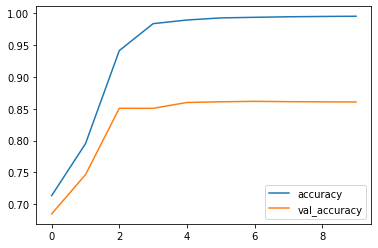

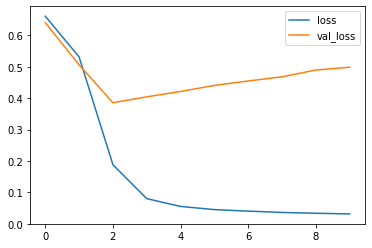

In [ ]:
gru_1_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('gru_1_accuracy.png', dpi=300)
gru_1_history_df[['loss', 'val_loss']].plot()
plt.savefig('gru_1_loss.png', dpi=300);

Jarak akurasi antara training dan validation, dan jarak loss antara training dan validation lebih jauh dari yang didapatkan pada lstm_4 (model lstm terbaik).

In [ ]:
y_hat_gru_1 = gru_1.predict(X_test)
y_hat_gru_1 = np.where(y_hat_gru_1 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_gru_1))

188/188 [==============================] - 11s 54ms/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2992
           1       0.85      0.87      0.86      3008

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



In [ ]:
accuracy_score(y_test, y_hat_gru_1)

0.8538333333333333

Akurasi testing juga lebih jelek dari lstm_4.

#### GRU 2

Karena masalah overfit terlihat memburuk dan testing score juga lebih jelek. Kita akan coba untuk menambahkan hidden layers GRU bukan Dense.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

gru_2 = Sequential()
gru_2.add(text_vect)
gru_2.add(embedding)
gru_2.add(Bidirectional(GRU(12, return_sequences=True)))
gru_2.add(Bidirectional(GRU(12, return_sequences=True)))
gru_2.add(Bidirectional(GRU(8, return_sequences=True)))
gru_2.add(Bidirectional(GRU(2)))
gru_2.add(Dense(1, activation='sigmoid'))

gru_2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

gru_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 bidirectional (Bidirectiona  (None, 1407, 24)         1728      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1407, 24)         2736      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 1407, 16)         1632      
 nal)                                                   

In [ ]:
%%time
gru_2_history = gru_2.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
47/47 [==============================] - 44s 645ms/step - loss: 0.6160 - accuracy: 0.7430 - val_loss: 0.5597 - val_accuracy: 0.7334
Epoch 2/10
47/47 [==============================] - 28s 594ms/step - loss: 0.3662 - accuracy: 0.8951 - val_loss: 0.4603 - val_accuracy: 0.8097
Epoch 3/10
47/47 [==============================] - 28s 592ms/step - loss: 0.2176 - accuracy: 0.9800 - val_loss: 0.4217 - val_accuracy: 0.8394
Epoch 4/10
47/47 [==============================] - 27s 582ms/step - loss: 0.1817 - accuracy: 0.9921 - val_loss: 0.4155 - val_accuracy: 0.8428
Epoch 5/10
47/47 [==============================] - 27s 576ms/step - loss: 0.1641 - accuracy: 0.9934 - val_loss: 0.4073 - val_accuracy: 0.8484
Epoch 6/10
47/47 [==============================] - 25s 532ms/step - loss: 0.1488 - accuracy: 0.9948 - val_loss: 0.4158 - val_accuracy: 0.8453
Epoch 7/10
47/47 [==============================] - 33s 712ms/step - loss: 0.1367 - accuracy: 0.9955 - val_loss: 0.4088 - val_accuracy: 0.8512

Waktu training yang dibutuhkan adalah 2 kali lipat dari yang dibutuhkan gru_1.

In [ ]:
gru_2_history_df = pd.DataFrame(gru_2_history.history)
gru_2_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.616042,0.743025,0.559660,0.733431
1,0.366202,0.895084,0.460259,0.809706
2,0.217592,0.980042,0.421697,0.839412
3,0.181675,0.992101,0.415478,0.842843
4,0.164051,0.993445,0.407313,0.848431
5,0.148770,0.994790,0.415809,0.845294
6,0.136652,0.995546,0.408819,0.851177
7,0.126720,0.995840,0.415062,0.848039
8,0.118132,0.995966,0.419365,0.847255
9,0.110666,0.996050,0.419391,0.849902


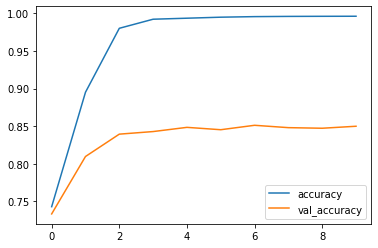

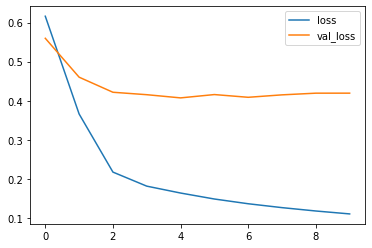

In [ ]:
gru_2_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('gru_2_accuracy.png', dpi=300)
gru_2_history_df[['loss', 'val_loss']].plot()
plt.savefig('gru_2_loss.png', dpi=300);

Overfit pada akurasi tampak lebih parah sedikit dari gru_1.

In [ ]:
y_hat_gru_2 = gru_2.predict(X_test)
y_hat_gru_2 = np.where(y_hat_gru_2 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_gru_2))

188/188 [==============================] - 23s 107ms/step
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2992
           1       0.84      0.85      0.85      3008

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



In [ ]:
accuracy_score(y_test, y_hat_gru_2)

0.8445

Akurasi pada testing set juga jadi lebih jelek dari gru_1.

#### GRU 3


Karena dengan menambahkan hidden layers GRU pada gru_2 membuat model lebih jelek dari gru_1, kita ingin mencoba mengurangi hidden layer tapi menambahkan jumlah neurons.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

gru_3 = Sequential()
gru_3.add(text_vect)
gru_3.add(embedding)
gru_3.add(Bidirectional(GRU(80, return_sequences=True)))
gru_3.add(Bidirectional(GRU(80)))
gru_3.add(Dense(1, activation='sigmoid'))

gru_3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

gru_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 bidirectional (Bidirectiona  (None, 1407, 160)        44160     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 160)              116160    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                        

In [ ]:
%%time
gru_3_history = gru_3.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
47/47 [==============================] - 42s 763ms/step - loss: 0.2740 - accuracy: 0.9030 - val_loss: 0.8220 - val_accuracy: 0.8517
Epoch 2/10
47/47 [==============================] - 36s 759ms/step - loss: 0.0267 - accuracy: 0.9952 - val_loss: 0.6115 - val_accuracy: 0.8517
Epoch 3/10
47/47 [==============================] - 36s 766ms/step - loss: 0.0224 - accuracy: 0.9965 - val_loss: 0.6075 - val_accuracy: 0.8547
Epoch 4/10
47/47 [==============================] - 39s 829ms/step - loss: 0.0201 - accuracy: 0.9967 - val_loss: 0.6026 - val_accuracy: 0.8586
Epoch 5/10
47/47 [==============================] - 36s 773ms/step - loss: 0.0180 - accuracy: 0.9971 - val_loss: 0.6483 - val_accuracy: 0.8460
Epoch 6/10
47/47 [==============================] - 35s 753ms/step - loss: 0.0144 - accuracy: 0.9974 - val_loss: 0.6825 - val_accuracy: 0.8566
Epoch 7/10
47/47 [==============================] - 35s 749ms/step - loss: 0.0117 - accuracy: 0.9981 - val_loss: 0.7431 - val_accuracy: 0.8498

Waktu yang dibutuhkan untuk training lebih lama dari gru_2 walaupun jumlah hidden layer pada gru_3 lebih sedikit.

In [ ]:
gru_3_history_df = pd.DataFrame(gru_3_history.history)
gru_3_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.274048,0.903025,0.822040,0.851667
1,0.026741,0.995210,0.611509,0.851667
2,0.022401,0.996471,0.607462,0.854706
3,0.020144,0.996681,0.602551,0.858627
4,0.018004,0.997101,0.648324,0.845980
5,0.014355,0.997437,0.682546,0.856569
6,0.011746,0.998109,0.743076,0.849804
7,0.009175,0.998445,0.717039,0.841961
8,0.007302,0.998782,0.780956,0.858824
9,0.005878,0.998908,0.814892,0.857059


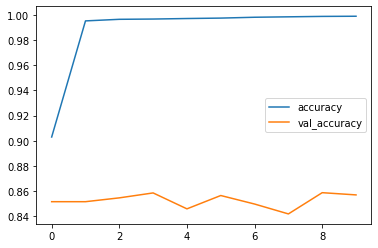

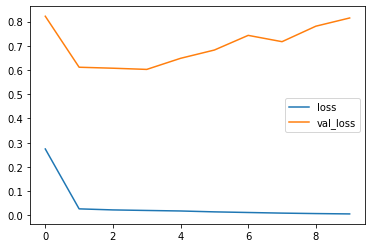

In [ ]:
gru_3_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('gru_3_accuracy.png', dpi=300)
gru_3_history_df[['loss', 'val_loss']].plot()
plt.savefig('gru_3_loss.png', dpi=300);

Overfit berdasarkan akurasi tidak membaik, sedangkan loss terlihat memburuk.

In [ ]:
y_hat_gru_3 = gru_3.predict(X_test)
y_hat_gru_3 = np.where(y_hat_gru_3 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_gru_3))

188/188 [==============================] - 14s 71ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2992
           1       0.84      0.87      0.86      3008

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



In [ ]:
accuracy_score(y_test, y_hat_gru_3)

0.8553333333333333

Akurasi pada testing set berkembang sedikit dari gru_2 tapi modelnya jelek.

#### Kesimpulan Analisis GRU

Modeling menggunakan GRU tampak tidak membuat model kita lebih baik dari LSTM. Maka dari itu kita tetap akan memilih lstm_4 sebagai model terbaik dari model-model yang sudah kita buat.  

**Note: Penulis sudah membuat 7 model GRU, tapi 4 model GRU lainnya punya performansi yang lebih jelek dari model-model GRU di atas, maka dari itu 4 model tersebut dihapus untuk mengurangi halaman notebook.**

### ANN (dibantu dengan GlobalAveragePooling1D)

#### Model 1

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model_1 = Sequential()
model_1.add(text_vect)
model_1.add(embedding)
model_1.add(GlobalAveragePooling1D())
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1070530   
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [ ]:
model_1_history = model_1.fit(X_train,
                              y_train,
                              epochs=10,
                              validation_data=(X_val, y_val))

Epoch 1/10
739/739 [==============================] - 20s 26ms/step - loss: 0.6687 - accuracy: 0.5966 - val_loss: 0.5316 - val_accuracy: 0.7603
Epoch 2/10
739/739 [==============================] - 17s 22ms/step - loss: 0.3409 - accuracy: 0.8718 - val_loss: 0.2971 - val_accuracy: 0.8824
Epoch 3/10
739/739 [==============================] - 16s 22ms/step - loss: 0.2242 - accuracy: 0.9142 - val_loss: 0.2746 - val_accuracy: 0.8932
Epoch 4/10
739/739 [==============================] - 16s 21ms/step - loss: 0.1706 - accuracy: 0.9379 - val_loss: 0.2820 - val_accuracy: 0.8858
Epoch 5/10
739/739 [==============================] - 16s 22ms/step - loss: 0.1391 - accuracy: 0.9496 - val_loss: 0.2743 - val_accuracy: 0.8977
Epoch 6/10
739/739 [==============================] - 16s 22ms/step - loss: 0.1099 - accuracy: 0.9612 - val_loss: 0.2871 - val_accuracy: 0.8943
Epoch 7/10
739/739 [==============================] - 16s 22ms/step - loss: 0.0907 - accuracy: 0.9684 - val_loss: 0.2990 - val_accuracy:

In [ ]:
model_1_history_df = pd.DataFrame(model_1_history.history)
model_1_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.668681,0.596556,0.531649,0.760316
1,0.340867,0.871753,0.297067,0.882428
2,0.224249,0.914191,0.274606,0.893189
3,0.170563,0.937928,0.282022,0.885785
4,0.139116,0.949606,0.274305,0.897730
5,0.109944,0.961158,0.287060,0.894274
6,0.090692,0.968393,0.299003,0.897631
7,0.067185,0.978336,0.333102,0.892399
8,0.054513,0.984345,0.340090,0.893682
9,0.041730,0.987899,0.371125,0.891905


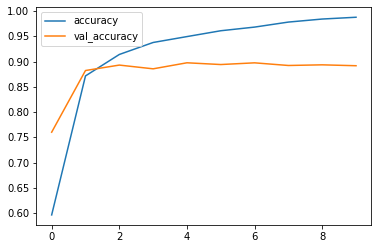

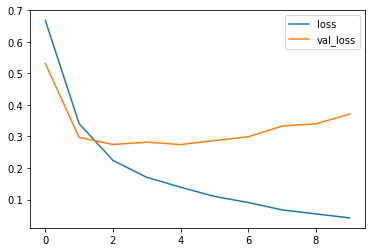

In [ ]:
model_1_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('model_1_accuracy.png', dpi=300)
model_1_history_df[['loss', 'val_loss']].plot()
plt.savefig('model_1_loss.png', dpi=300);

Overfit pada akurasi membaik ke sekitar 10% dari sekitar 15% pada LSTM dan GRU.

In [ ]:
y_hat_1 = model_1.predict(X_test)
y_hat_1 = np.where(y_hat_1 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_1))

187/187 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3027
           1       0.88      0.90      0.89      2932

    accuracy                           0.89      5959
   macro avg       0.89      0.89      0.89      5959
weighted avg       0.89      0.89      0.89      5959



In [ ]:
accuracy_score(y_test, y_hat_1)

0.8900822285618393

Akurasi kita juga meningkat ke 89%

#### Model 2

Mencoba menangani overfit dengan menambahkan hidden layer namun ditemani oleh dropout dan mengubah learning rate Adam.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model_2 = Sequential()
model_2.add(text_vect)
model_2.add(embedding)
model_2.add(BatchNormalization())
model_2.add(GlobalAveragePooling1D())
# model_2.add(Dropout(0.25))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics='accuracy')

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1070530   
                                                                 
 batch_normalization (BatchN  (None, 1407, 10)         40        
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                352       
                                                        

In [ ]:
%%time
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=10,
                              validation_data=(X_val, y_val),
                              verbose=2)

Epoch 1/10
739/739 - 23s - loss: 0.1858 - accuracy: 0.9324 - val_loss: 0.5123 - val_accuracy: 0.8092 - 23s/epoch - 31ms/step
Epoch 2/10
739/739 - 25s - loss: 0.1448 - accuracy: 0.9476 - val_loss: 8.1021 - val_accuracy: 0.5296 - 25s/epoch - 34ms/step
Epoch 3/10
739/739 - 28s - loss: 0.1239 - accuracy: 0.9586 - val_loss: 0.6349 - val_accuracy: 0.8403 - 28s/epoch - 38ms/step
Epoch 4/10
739/739 - 20s - loss: 0.0996 - accuracy: 0.9649 - val_loss: 2.4782 - val_accuracy: 0.6789 - 20s/epoch - 27ms/step
Epoch 5/10
739/739 - 19s - loss: 0.0818 - accuracy: 0.9743 - val_loss: 2.4818 - val_accuracy: 0.6564 - 19s/epoch - 26ms/step
Epoch 6/10
739/739 - 21s - loss: 0.0798 - accuracy: 0.9731 - val_loss: 1.6172 - val_accuracy: 0.6571 - 21s/epoch - 28ms/step
Epoch 7/10
739/739 - 19s - loss: 0.0662 - accuracy: 0.9779 - val_loss: 5.7498 - val_accuracy: 0.5848 - 19s/epoch - 26ms/step
Epoch 8/10
739/739 - 21s - loss: 0.0550 - accuracy: 0.9799 - val_loss: 2.0119 - val_accuracy: 0.7501 - 21s/epoch - 28ms/step


In [ ]:
model_2_history_df = pd.DataFrame(model_2_history.history)
model_2_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.185794,0.932386,0.512255,0.809181
1,0.144763,0.947576,8.102060,0.529615
2,0.123940,0.958577,0.634881,0.840276
3,0.099647,0.964881,2.478168,0.678875
4,0.081808,0.974274,2.481782,0.656367
5,0.079814,0.973090,1.617157,0.657058
6,0.066173,0.977913,5.749775,0.584798
7,0.054967,0.979860,2.011877,0.750148
8,0.062904,0.978844,6.575869,0.573741
9,0.046124,0.984768,11.480441,0.536624


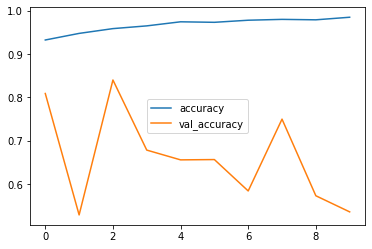

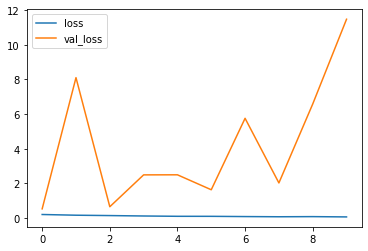

In [ ]:
model_2_history_df[['accuracy', 'val_accuracy']].plot()
model_2_history_df[['loss', 'val_loss']].plot();

Proses penambahan hidden layer dan ditemani oleh dropout malah membuat model kita overfit.

In [ ]:
y_hat_2 = model_2.predict(X_test)
y_hat_2 = np.where(y_hat_2 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_2))

187/187 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.92      0.09      0.16      3027
           1       0.51      0.99      0.68      2932

    accuracy                           0.53      5959
   macro avg       0.71      0.54      0.42      5959
weighted avg       0.72      0.53      0.42      5959



In [ ]:
accuracy_score(y_test, y_hat_2)

0.5331431448229569

Akurasi model kita di testing set jatuh sekali.

#### Model 3

Kita ingin mencoba penambahan hidden layer ditemani dengan dropout yang kedua. Dan mengubah batch size jadi 50 agar proses training lebih cepat.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model_3 = Sequential()
model_3.add(text_vect)
model_3.add(embedding)
# model_3.add(Dropout(0.25))
model_3.add(GlobalAveragePooling1D())
model_3.add(Dense(80, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(80, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(60, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(40, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(10, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics='accuracy')

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 80)                880       
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6

In [ ]:
%%time
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=50,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
476/476 [==============================] - 16s 30ms/step - loss: 0.2118 - accuracy: 0.9050 - val_loss: 1.2769 - val_accuracy: 0.8593
Epoch 2/10
476/476 [==============================] - 12s 26ms/step - loss: 0.0870 - accuracy: 0.9748 - val_loss: 1.1893 - val_accuracy: 0.8634
Epoch 3/10
476/476 [==============================] - 12s 25ms/step - loss: 0.0445 - accuracy: 0.9878 - val_loss: 0.9272 - val_accuracy: 0.7961
Epoch 4/10
476/476 [==============================] - 11s 23ms/step - loss: 0.0922 - accuracy: 0.9769 - val_loss: 3.7776 - val_accuracy: 0.8487
Epoch 5/10
476/476 [==============================] - 13s 27ms/step - loss: 0.5580 - accuracy: 0.6255 - val_loss: 0.6940 - val_accuracy: 0.4905
Epoch 6/10
476/476 [==============================] - 13s 28ms/step - loss: 0.5700 - accuracy: 0.6074 - val_loss: 2.7316 - val_accuracy: 0.8489
Epoch 7/10
476/476 [==============================] - 12s 26ms/step - loss: 0.3261 - accuracy: 0.8672 - val_loss: 3.5965 - val_accuracy:

In [ ]:
model_3_history_df = pd.DataFrame(model_3_history.history)
model_3_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.211811,0.905042,1.276885,0.859314
1,0.086993,0.974832,1.189254,0.863431
2,0.044464,0.987815,0.927223,0.796078
3,0.092151,0.976891,3.777605,0.848725
4,0.558034,0.625504,0.693997,0.490490
5,0.569981,0.607395,2.731610,0.848922
6,0.326127,0.867185,3.596520,0.850784
7,0.128782,0.957899,6.458671,0.831176
8,0.074020,0.976513,7.864134,0.854706
9,0.358744,0.857395,0.439854,0.829510


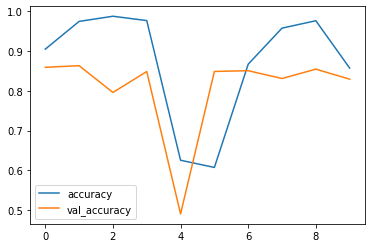

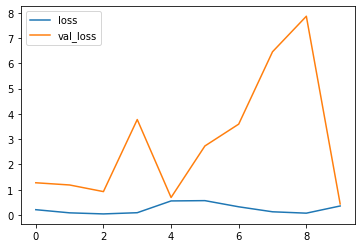

In [ ]:
model_3_history_df[['accuracy', 'val_accuracy']].plot()
model_3_history_df[['loss', 'val_loss']].plot();

Model kita masih overfitting.

In [ ]:
y_hat_3 = model_3.predict(X_test)
y_hat_3 = np.where(y_hat_3 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_3))

188/188 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      2992
           1       0.76      0.95      0.84      3008

    accuracy                           0.82      6000
   macro avg       0.85      0.82      0.82      6000
weighted avg       0.85      0.82      0.82      6000



In [ ]:
accuracy_score(y_test, y_hat_3)

0.8238333333333333

Walaupun model ann 3 dapat akurasi yang bagus. Tapi perlu diingat bahwa model ini memiliki performansi jelek.

#### Model 4

Karena penambahan hidden layer membuat model kita overfit, kita akan melakukan hal sebaliknya, yaitu mengurangi hidden layer. Kita juga akan mengubah batch size jadi 100 agar lebih cepat saat training.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model_4 = Sequential()
model_4.add(text_vect)
model_4.add(embedding)
model_4.add(GlobalAveragePooling1D())
model_4.add(Dense(80, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics='accuracy')

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1069810   
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 80)                880       
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8

In [ ]:
%%time
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=100,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
238/238 [==============================] - 10s 36ms/step - loss: 0.1311 - accuracy: 0.9663 - val_loss: 0.5026 - val_accuracy: 0.8661
Epoch 2/10
238/238 [==============================] - 7s 28ms/step - loss: 0.0160 - accuracy: 0.9958 - val_loss: 0.6530 - val_accuracy: 0.8637
Epoch 3/10
238/238 [==============================] - 8s 34ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.8437 - val_accuracy: 0.8528
Epoch 4/10
238/238 [==============================] - 7s 28ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.7584 - val_accuracy: 0.8657
Epoch 5/10
238/238 [==============================] - 9s 39ms/step - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.7143 - val_accuracy: 0.8655
Epoch 6/10
238/238 [==============================] - 8s 33ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.8739 - val_accuracy: 0.8598
Epoch 7/10
238/238 [==============================] - 8s 32ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.8840 - val_accuracy: 0.863

In [ ]:
model_4_history_df = pd.DataFrame(model_4_history.history)
model_4_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.131118,0.966303,0.502555,0.866078
1,0.015992,0.995840,0.653002,0.863725
2,0.008193,0.997773,0.843747,0.852843
3,0.004171,0.998824,0.758434,0.865686
4,0.024026,0.993109,0.714324,0.865490
5,0.002115,0.999622,0.873942,0.859804
6,0.001343,0.999874,0.883997,0.863431
7,0.001043,0.999832,0.994179,0.858627
8,0.000683,0.999874,0.951386,0.865392
9,0.000472,0.999958,0.995529,0.864706


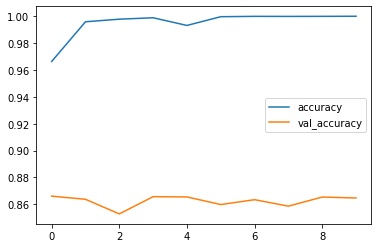

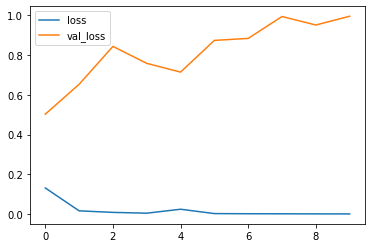

In [ ]:
model_4_history_df[['accuracy', 'val_accuracy']].plot()
model_4_history_df[['loss', 'val_loss']].plot();

Model 4 memiliki performansi yang lebih stabil dibandingkan dengan model 3. Meskipun begitu, model 4 masih memiliki jarak loss yang sangat besar antara training dan validation.

In [ ]:
y_hat_4 = model_4.predict(X_test)
y_hat_4 = np.where(y_hat_4 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_4))

188/188 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      2992
           1       0.84      0.91      0.87      3008

    accuracy                           0.86      6000
   macro avg       0.87      0.86      0.86      6000
weighted avg       0.87      0.86      0.86      6000



In [ ]:
accuracy_score(y_test, y_hat_4)

0.8633333333333333

Akurasi model 4 lebih besar dari model 3 dan 2.

#### Model 5

Karena pengurangan hidden layer juga masih belum membuat model kita good fit. Kita ingin mencoba mengubah activation function dari relu ke versi yang 'leaky'. Kita juga akan mengubah learning rate Adam jadi 0.0001.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model_5 = Sequential()
model_5.add(text_vect)
model_5.add(embedding)
model_5.add(GlobalAveragePooling1D())
model_5.add(Dense(100, activation=tf.keras.layers.LeakyReLU()))
model_5.add(Dropout(0.25))
model_5.add(Dense(80, activation=tf.keras.layers.LeakyReLU()))
model_5.add(Dense(40, activation=tf.keras.layers.LeakyReLU()))
model_5.add(Dense(20, activation=tf.keras.layers.LeakyReLU()))
model_5.add(Dense(10, activation=tf.keras.layers.LeakyReLU()))
model_5.add(Dropout(0.25))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics='accuracy')

model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1070530   
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 100)               1100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                8

In [ ]:
%%time
model_5_history = model_5.fit(X_train,
                              y_train,
                              epochs=10,
                              batch_size=50,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/10
473/473 [==============================] - 22s 36ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4956
Epoch 2/10
473/473 [==============================] - 18s 37ms/step - loss: 0.6930 - accuracy: 0.5070 - val_loss: 0.6929 - val_accuracy: 0.4956
Epoch 3/10
473/473 [==============================] - 19s 39ms/step - loss: 0.6891 - accuracy: 0.5610 - val_loss: 0.6715 - val_accuracy: 0.6143
Epoch 4/10
473/473 [==============================] - 19s 40ms/step - loss: 0.5362 - accuracy: 0.7793 - val_loss: 0.4047 - val_accuracy: 0.8412
Epoch 5/10
473/473 [==============================] - 22s 47ms/step - loss: 0.3466 - accuracy: 0.8639 - val_loss: 0.3473 - val_accuracy: 0.8474
Epoch 6/10
473/473 [==============================] - 18s 38ms/step - loss: 0.2829 - accuracy: 0.8920 - val_loss: 0.3306 - val_accuracy: 0.8540
Epoch 7/10
473/473 [==============================] - 16s 35ms/step - loss: 0.2475 - accuracy: 0.9092 - val_loss: 0.2929 - val_accuracy:

In [ ]:
model_5_history_df = pd.DataFrame(model_5_history.history)
model_5_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.693158,0.502539,0.693184,0.495558
1,0.693021,0.507024,0.692926,0.495558
2,0.689132,0.561014,0.671464,0.614314
3,0.536233,0.779301,0.404709,0.841165
4,0.346594,0.863883,0.347302,0.847384
5,0.282863,0.891978,0.330597,0.853998
6,0.247518,0.909241,0.292856,0.879961
7,0.219751,0.920496,0.282067,0.888450
8,0.199600,0.927097,0.313090,0.876111
9,0.179655,0.937167,0.301942,0.878973


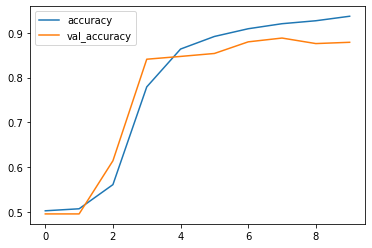

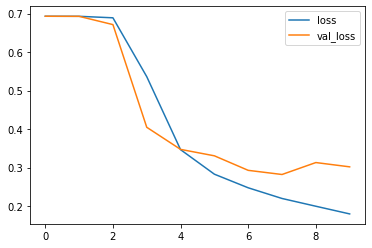

In [ ]:
model_5_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('model_5_accuracy.png', dpi=300)
model_5_history_df[['loss', 'val_loss']].plot()
plt.savefig('model_5_loss.png', dpi=300);

Kita bisa melihat bahwa model 5 kita sudah bisa mengurangi jarak overfit, walaupun akurasi yang dimiliki tidak lebih besar dari model 1.

In [ ]:
y_hat_5 = model_5.predict(X_test)
y_hat_5 = np.where(y_hat_5 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_5))

187/187 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      3027
           1       0.83      0.94      0.88      2932

    accuracy                           0.88      5959
   macro avg       0.88      0.88      0.88      5959
weighted avg       0.89      0.88      0.88      5959



In [ ]:
accuracy_score(y_test, y_hat_5)

0.8790065447222688

Akurasi model 5 pada testing set juga tidak jauh dari model 1. Maka dari itu, jika penulis diharuskan memilih model terbaik dari model-model yang sudah pernah dibuat, model 5 ann adalah model terbaik karena overfit yang tidak terlalu besar dan akurasi model pada testing set yang masih terbilang besar.

#### Model 6

Karena model 5 ann sudah bagus secara fit dan akurasi, kita tidak akan mengubah modelnya, tapi kita akan mencoba proses trainingnya. Kita akan mencoba 30 kali training dan batch size = 512.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model_6 = Sequential()
model_6.add(text_vect)
model_6.add(embedding)
model_6.add(GlobalAveragePooling1D())
model_6.add(Dense(100, activation=tf.keras.layers.LeakyReLU()))
model_6.add(Dropout(0.25))
model_6.add(Dense(80, activation=tf.keras.layers.LeakyReLU()))
model_6.add(Dense(40, activation=tf.keras.layers.LeakyReLU()))
model_6.add(Dense(20, activation=tf.keras.layers.LeakyReLU()))
model_6.add(Dense(10, activation=tf.keras.layers.LeakyReLU()))
model_6.add(Dropout(0.25))
model_6.add(Dense(1, activation='sigmoid'))

model_6.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics='accuracy')

model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1407)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1407, 10)          1070530   
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 100)               1100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                8

In [ ]:
%%time
model_6_history = model_6.fit(X_train,
                              y_train,
                              epochs=30,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/30
47/47 [==============================] - 10s 183ms/step - loss: 0.6920 - accuracy: 0.5926 - val_loss: 0.6908 - val_accuracy: 0.7176
Epoch 2/30
47/47 [==============================] - 5s 115ms/step - loss: 0.6892 - accuracy: 0.6828 - val_loss: 0.6879 - val_accuracy: 0.8640
Epoch 3/30
47/47 [==============================] - 9s 187ms/step - loss: 0.6844 - accuracy: 0.7421 - val_loss: 0.6818 - val_accuracy: 0.8503
Epoch 4/30
47/47 [==============================] - 5s 117ms/step - loss: 0.6750 - accuracy: 0.7837 - val_loss: 0.6700 - val_accuracy: 0.8695
Epoch 5/30
47/47 [==============================] - 7s 140ms/step - loss: 0.6573 - accuracy: 0.8334 - val_loss: 0.6508 - val_accuracy: 0.8107
Epoch 6/30
47/47 [==============================] - 6s 130ms/step - loss: 0.6270 - accuracy: 0.8467 - val_loss: 0.6142 - val_accuracy: 0.8713
Epoch 7/30
47/47 [==============================] - 5s 116ms/step - loss: 0.5794 - accuracy: 0.8767 - val_loss: 0.5612 - val_accuracy: 0.8774
Epoch

In [ ]:
model_6_history_df = pd.DataFrame(model_6_history.history)
model_6_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.691977,0.592621,0.690850,0.717572
1,0.689214,0.682830,0.687872,0.863968
2,0.684431,0.742067,0.681812,0.850345
3,0.674998,0.783659,0.670030,0.869497
4,0.657310,0.833376,0.650829,0.810661
5,0.626973,0.846746,0.614203,0.871273
6,0.579374,0.876703,0.561234,0.877394
7,0.513428,0.889735,0.494135,0.877789
8,0.437376,0.901879,0.428624,0.882330
9,0.369609,0.905306,0.372029,0.886673


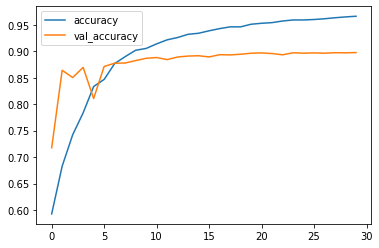

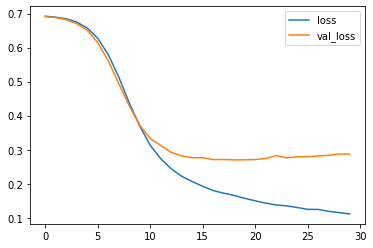

In [ ]:
model_6_history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig('model_6_accuracy.png', dpi=300)
model_6_history_df[['loss', 'val_loss']].plot()
plt.savefig('model_6_loss.png', dpi=300);

Model 6 kita memiliki performasi yang hampir sama dengan model 5. Kita juga bisa melihat bahwa akurasi pada saat validation tidak bisa melebihi titik 90% seperti model-model sebelumnya.

In [ ]:
print(f'Rata-rata akurasi saat training : {np.round(np.mean(model_6_history_df.accuracy), 3)}')
print(f'Rata-rata akurasi saat validation : {np.round(np.mean(model_6_history_df.val_accuracy), 3)}')

Rata-rata akurasi saat training : 0.9
Rata-rata akurasi saat validation : 0.879


Kita bisa melihat bahwa secara rata-rata akurasi model kita saat training dan validation tidak terlalu berbeda.

In [ ]:
y_hat_6 = model_6.predict(X_test)
y_hat_6 = np.where(y_hat_6 >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_6))

187/187 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3027
           1       0.90      0.89      0.89      2932

    accuracy                           0.90      5959
   macro avg       0.90      0.90      0.90      5959
weighted avg       0.90      0.90      0.90      5959



In [ ]:
accuracy_score(y_test, y_hat_6)

0.8966269508306763

Kita mendapatkan akurasi terbaik untuk testing set dengan menggunakan model ann 6.

#### Kesimpulan Analisis ANN

Dengan melakukan modeling memakai ANN dan GlobalAveragePooling1D kita mendapatkan model terbaik dari model-model yang pernah kita buat, yaitu model 6. Model 6 dapat memperbaiki masalah overfit dan akurasi. Model 6 dapat menghasilkan akurasi training, validation, dan testing yang hampir sama.   

Maka dari itu jika perusahaan kita ingin memakai deep learning untuk day-to-day business, model 6 adalah model yang akan dipakai.

**Note: Penulis sudah membuat 13 model ann, namun 7 model yang lain punya performansi yang hampir sama dengan model-model ann lainnya, maka dari itu 7 model tersebut dihapus untuk mengurangi panjang halaman notebook.**

# 7 - Mengecek Hasil Prediksi Model

In [ ]:
text_1 = 'the movie is bad.'
np.where(model_6.predict([[text_1]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 136ms/step


array([[0]])

model 6 dapat predikisi text di atas dengan benar sebagai negatif.

In [ ]:
text_2 = 'the movie is not bad.'
np.where(model_6.predict([[text_2]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 72ms/step


array([[0]])

model 6 akan prediksi text netral seperti di atas sebagai negatif.

In [ ]:
text_4 = 'the movie is good.'
np.where(model_6.predict([[text_4]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 156ms/step


array([[0]])

model 6 memprediksi text di atas sebagai negatif, yang mana salah.

In [ ]:
text_5 = 'good movie.'
np.where(model_6.predict([[text_5]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 157ms/step


array([[1]])

model 6 memprediksi text di atas dengan benar sebagai text positif, padahal textnya hampir sama dengan text_4, sama-sama mengandung good dan tidak ada kata negatif.

In [ ]:
text_6 = 'the movie is amazing.'
np.where(model_6.predict([[text_6]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 98ms/step


array([[1]])

model 6 dapat memprediksi text di atas dengan benar walaupun textnya hampir sama dengan text_4, yang beda hanya dari good diganti amazing.  

Dari sini penulis menduga bahwa kata the dan is mendominasi kata good, yang mana akan menganggap text tersebut sebagai negatif. Sedangkat kata the dan is tidak mendominasi kata amazing, yang mana textnya akan dianggap positif.  

Penulis berpendapat lebih baik kita juga menambah sentimen netral untuk menampung kata-kata yang tidak negatif maupun positif.

In [ ]:
text_7 = 'the movie is not amazing.'
np.where(model_6.predict([[text_7]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 118ms/step


array([[1]])

model 6 salah memprediksi text_7 sebagai text positif. Padalah text tersebut netral atau negatif.

In [ ]:
text_8 = 'not'
np.where(model_6.predict([[text_7]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 113ms/step


array([[1]])

Penulis mengira bahwa kata amazing mendominasi kata not, maka textnya diprediksi positif. Namun ternyata kata not dianggap sebagai positif oleh model 6.

In [ ]:
# text_8 = 'The Movie is wonderful.'
# np.where(model_6.predict([[text_8]]) >= 0.5, 1, 0)

In [ ]:
# text_9 = 'The Movie is not wonderful.'
# np.where(model_6.predict([[text_9]]) >= 0.5, 1, 0)

In [ ]:
text_10 = "My favorite film is Stranger Things. The movie was launched in 2016 and a genre of this film is sci-fi. The movie is about a group of boys that have to find the truth and protect the city from a monster. I like this movie because of the mood and tone, it seems like American in the old days."
np.where(model_6.predict([[text_10]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 168ms/step


array([[0]])

Source text: https://learnenglishteens.britishcouncil.org/skills/writing/a2-writing/film-review   
Dari user mmmmm.

Text_10 diprediksi sebagai text negatif padahal text_10 adalah review positif.  
Kita akan mencoba menyingkat review di atas.

In [ ]:
text_11 = "My favorite film is Stranger Things. I like this movie."
np.where(model_6.predict([[text_11]]) >= 0.5, 1, 0)

1/1 [==============================] - 0s 83ms/step


array([[1]])

Setelah text_10 disingkat. Review tersebut baru bisa diprediksi dengan benar oleh model 6 sebagai review positif.

# 8 - Kelebihan dan Kelemahan Model Terbaik (Model 6)

## Kelebihan

* Model 6 dapat mengatasi overfit yang didapat pada model-model lain.
* Model 6 juga dapat ditraining lumayan cepat dengan tetap mendapatkan akurasi yang bagus.

## Kelemahan

* Modeling sering menghasilkan model yang overfit, model 6 juga tidak terlalu berbeda. Walaupun secara rata-rata model kita fit, tapi secara visual model kita masih dibilang overfit.  
* Akurasi pada validation data tidak bisa melebihi angka 90%, yang mana penulis menduga yang bermasalah adalah bukan model kita tapi datanya.

# 9 - Model Improvements yang dapat dilakukan selanjutnya

* Menambah label netral
* Melakukan preprocessing yang lebih detail, seperti stemming, dll.
* Menghilangkan kata-kata yang tidak penting atau jarang sekali muncul
* Mencoba functional model
* Mencoba transfer learning (Penulis tidak menggunakan transfer learning karena setelah dicari-cari belum dapat yang untuk movie)

# 10 - Overall Analysis (Kesimpulan)

Data kita memiliki balance yang bagus, yaitu hampir 50:50. Secara rata-rata panjang review yang memiliki sentimen positif juga tidak berbeda dengan panjang review yang memiliki sentimen negatif.  

Modeling menggunakan RNN (SimpleRNN, LSTM, GRU) menghasilkan model yang overfit parah dan akurasi yang tidak terlalu bagus. Waktu training yang dibutuhkan untuk mentraining model RNN juga lama. Maka dari itu kita juga mencoba modeling dengan menggunakan ANN.  

Modeling dengan ANN dan GlobalAveragePooling1D dapat menghasilkan model dengan lumayan cepat. Beberapa model-model ANN dapat menghasilkan akurasi yang lebih bagus dari RNN dan overfit yang tidak separah RNN.  

Setelah banyak kali kita melakukan modeling, kita memilih model 6 ANN sebagai model terbaik dari model-model yang sudah kita buat. Namun model ini belum bisa digunakan untuk day-to-day business karena masih bisa dibilang overfitting dan model ini masih sering melakukan prediksi yang salah.  

Prediksi salah tersebut diyakini oleh penulis disebabkan karena kita tidak mempertimbangkan sentimen netral dan proses preprocessing yang kurang detail.  

Maka dari itu, kita memerlukan proses lebih lanjut terhadap model ini sebelum dipakai untuk day-to-day business.

# 11 - Rekomendasi Bisnis

* Untuk sementara model deep learning kita jangan dipakai dulu, karena modelnya masih bisa dibilang overfit dan sering melakukan prediksi kalimat sederhana.
* Menambahkan sentimen netral, karena menurut penulis jika hanya positif dan negatif terlalu sempit dan menyebabkan model kita salah prediksi.

# 12 - Inference

Karena kita pakai text vectorization dengan weights, kita tidak bisa save model ke h5.  
Kita juga tidak bisa save_weights ke h5, dll.  
Setelah dilakukan beberapa solusi seperti tf-nightly, save model sabagi tf, dll, inference belum dapat dilakukan.  
Maka dari itu penulis belum bisa melakukan model inference dan deployment.